In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
# connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ambil dataset dari gdrive
df = pd.read_csv('/content/drive/MyDrive/Final Project/dataset.csv')
df.head()

,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,...,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,5,True,3,162.0,False,NaN,NaN,NaN,NaN,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,2,True,4,147.0,False,NaN,NaN,40.92,NaN,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,1,True,6,0.0,True,NaN,NaN,NaN,NaN,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,1,False,4,161.0,False,NaN,NaN,NaN,NaN,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,2,False,1,765.0,False,NaN,NaN,NaN,NaN,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Machine_ID                  500000 non-null  object 
 1   Machine_Type                500000 non-null  object 
 2   Installation_Year           500000 non-null  int64  
 3   Operational_Hours           500000 non-null  int64  
 4   Temperature_C               500000 non-null  float64
 5   Vibration_mms               500000 non-null  float64
 6   Sound_dB                    500000 non-null  float64
 7   Oil_Level_pct               500000 non-null  float64
 8   Coolant_Level_pct           500000 non-null  float64
 9   Power_Consumption_kW        500000 non-null  float64
 10  Last_Maintenance_Days_Ago   500000 non-null  int64  
 11  Maintenance_History_Count   500000 non-null  int64  
 12  Failure_History_Count       500000 non-null  int64  
 13  AI_Supervision

# Data Understanding

Data ini diambil : https://www.kaggle.com/datasets/canozensoy/industrial-iot-dataset-synthetic

Dataset ini berisi informasi historis dari 500.000 catatan operasional berbagai mesin industri, dengan tujuan utama untuk **Memprediksi kemungkinan kegagalan mesin dalam jangka waktu 7 hari ke depan.**

Setiap baris mewakili kondisi satu mesin pada satu titik waktu, dilengkapi dengan variabel-variabel seperti tipe mesin, lama operasional, suhu, getaran, tingkat oli, konsumsi daya, serta histori perawatan dan kerusakan. Selain itu, terdapat beberapa fitur kategorikal seperti jenis mesin dan pengawasan berbasis AI, serta fitur target Failure_Within_7_Days yang menunjukkan apakah mesin mengalami kegagalan dalam waktu dekat.



| **Kolom**                    | **Penjelasan Arti**                                              |
| ---------------------------- | ----------------------------------------------------------------- |
| `Machine_ID`                 | ID unik untuk tiap mesin                                          |
| `Machine_Type`               | Jenis mesin (mungkin berdasarkan model atau kategori produksi)    |
| `Installation_Year`          | Tahun pemasangan mesin                                            |
| `Operational_Hours`          | Total jam operasi mesin sejak awal digunakan                      |
| `Temperature_C`              | Suhu operasi mesin dalam derajat Celsius                          |
| `Vibration_mms`              | Getaran mesin dalam mm/s                                          |
| `Sound_dB`                   | Tingkat kebisingan dalam desibel                                  |
| `Oil_Level_pct`              | Persentase level oli dalam tangki mesin                           |
| `Coolant_Level_pct`          | Persentase level cairan pendingin                                 |
| `Power_Consumption_kW`       | Konsumsi daya mesin dalam kilowatt                                |
| `Last_Maintenance_Days_Ago`  | Berapa hari yang lalu mesin terakhir kali diservis                |
| `Maintenance_History_Count`  | Total jumlah perawatan/servis yang pernah dilakukan               |
| `Failure_History_Count`      | Total jumlah kerusakan yang pernah terjadi pada mesin             |
| `AI_Supervision`             | Apakah mesin diawasi sistem AI (ya/tidak - boolean)               |
| `Error_Codes_Last_30_Days`   | Jumlah kode error yang tercatat dalam 30 hari terakhir            |
| `Remaining_Useful_Life_days` | Perkiraan sisa umur pakai mesin dalam hari                        |
| `Failure_Within_7_Days`      | Apakah mesin gagal dalam 7 hari ke depan (ya/tidak) |
| `Laser_Intensity`            | Intensitas sinar laser (jika mesin menggunakan teknologi laser)   |
| `Hydraulic_Pressure_bar`     | Tekanan hidrolik dalam bar                                        |
| `Coolant_Flow_L_min`         | Aliran cairan pendingin dalam liter per menit                     |
| `Heat_Index`                 | Indeks panas gabungan (mungkin kombinasi suhu, kelembaban, dll)   |
| `AI_Override_Events`         | Jumlah event AI mengambil alih kendali karena anomali/kerusakan   |


# Data Cleaning

In [5]:
df.describe()

,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
count,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,15156.000000,30340.000000,45624.000000,45214.000000,500000.000000
mean,2019.962360,50012.424764,59.997682,9.99114,75.003477,69.456568,64.114159,149.922161,182.257866,5.003128,2.000588,3.000840,452.422338,74.995513,119.917514,39.984794,499.760966,0.602098
std,11.829812,28861.849078,14.986973,4.99953,9.990791,18.847444,23.152998,79.955937,105.552537,2.238043,1.413087,1.730541,288.971269,10.035133,15.017048,9.989653,50.012057,1.203647
min,2000.000000,0.000000,-15.730000,-17.82000,23.650000,0.000000,0.000000,-222.740000,0.000000,0.000000,0.000000,0.000000,0.000000,34.970000,52.680000,-0.160000,296.440000,0.000000
25%,2010.000000,25055.000000,49.890000,6.62000,68.270000,56.540000,48.130000,96.090000,91.000000,3.000000,1.000000,2.000000,200.000000,68.250000,109.820000,33.200000,465.940000,0.000000
50%,2020.000000,49973.000000,60.000000,10.00000,75.000000,70.030000,65.010000,149.950000,182.000000,5.000000,2.000000,3.000000,451.000000,74.950000,119.860000,40.030000,499.770000,0.000000
75%,2030.000000,74995.000000,70.050000,13.36000,81.730000,83.540000,81.840000,203.900000,274.000000,6.000000,3.000000,4.000000,700.000000,81.682500,130.072500,46.750000,533.307500,1.000000
max,2040.000000,100000.000000,127.330000,32.47000,120.700000,100.000000,100.000000,544.200000,365.000000,18.000000,12.000000,13.000000,1133.000000,114.320000,185.380000,80.790000,694.170000,11.000000


In [6]:
 # check data duplicate

df.duplicated().sum()

np.int64(0)

In [7]:
# check nan

df.isna().sum()

,0
Machine_ID,0
Machine_Type,0
Installation_Year,0
Operational_Hours,0
Temperature_C,0
Vibration_mms,0
Sound_dB,0
Oil_Level_pct,0
Coolant_Level_pct,0
Power_Consumption_kW,0


di dapatkan ada banyak sekali data NaN pada kolom : Laser Intensity, Hydraulic Pressure bar, Coolant Flow L min, dan Heat Index, jadi kita akan drop 4 kolom ini.


In [8]:
data = df.copy()

In [9]:
# drop 4 kolom dan Machine ID

data.drop(['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index', 'Machine_ID'], axis=1, inplace=True)
data.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,True,3,162.0,False,2
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,True,4,147.0,False,2
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,True,6,0.0,True,2
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,False,4,161.0,False,0
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,False,1,765.0,False,0


In [10]:
# check null kembali

data.isna().sum()

,0
Machine_Type,0
Installation_Year,0
Operational_Hours,0
Temperature_C,0
Vibration_mms,0
Sound_dB,0
Oil_Level_pct,0
Coolant_Level_pct,0
Power_Consumption_kW,0
Last_Maintenance_Days_Ago,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Machine_Type                500000 non-null  object 
 1   Installation_Year           500000 non-null  int64  
 2   Operational_Hours           500000 non-null  int64  
 3   Temperature_C               500000 non-null  float64
 4   Vibration_mms               500000 non-null  float64
 5   Sound_dB                    500000 non-null  float64
 6   Oil_Level_pct               500000 non-null  float64
 7   Coolant_Level_pct           500000 non-null  float64
 8   Power_Consumption_kW        500000 non-null  float64
 9   Last_Maintenance_Days_Ago   500000 non-null  int64  
 10  Maintenance_History_Count   500000 non-null  int64  
 11  Failure_History_Count       500000 non-null  int64  
 12  AI_Supervision              500000 non-null  bool   
 13  Error_Codes_La

In [12]:
# save dataset

data.to_csv('dataset_clean.csv', index=False)

# EDA

1. Bagaimana bentuk distribusi dari Failure_within_7_days

2. Bagaimana Korelasi kolom target dengan kolom numerik lainnya

3. Apakah pengawasan AI berdampak mengurangi kegagalan?


Tambahan

1. Apakah mesin yang terakhir diperbaiki lebih dari 100 hari lalu (Last_Maintenance_Days_Ago) lebih berisiko gagal?

2. Apakah semakin sering mesin dirawat (Maintenance_History_Count), semakin panjang Remaining_Useful_Life_days?

3. Apakah semakin tinggi suhu mesin maka konsumsi tenaga semakin tinggi juga? (Temperature_c vs Power_Consumption_kW)

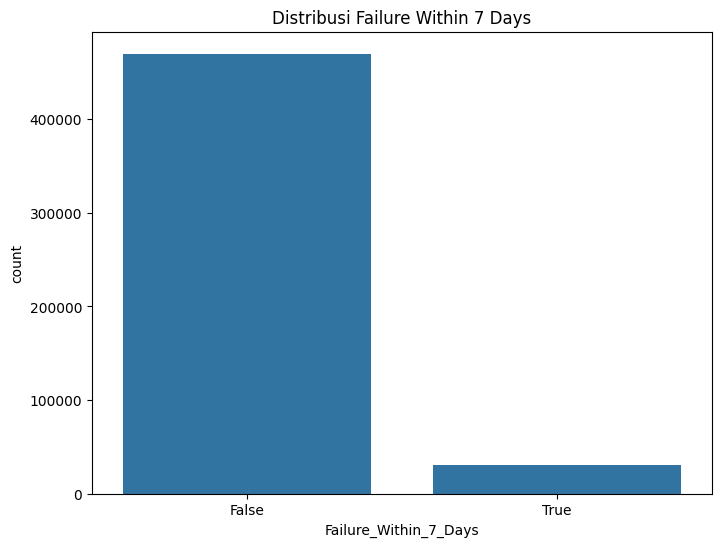

In [13]:
# 1. Bagaimana bentuk distribusi dari failure_within_7_days

plt.figure(figsize=(8, 6))
sns.countplot(x='Failure_Within_7_Days', data=data)
plt.title('Distribusi Failure Within 7 Days')
plt.show()

In [14]:
# value count

data['Failure_Within_7_Days'].value_counts()

,count
Failure_Within_7_Days,
False,469968
True,30032


berdasarkan gambar dan setelah di lakukan value count pada kolom target, di dapatkan kejadian Imbalance dimana jumlah data mesin yang mengalami kegagalan sangat berbeda jauh dengan mesin yang tidak mengalami kegagalan. Sehingga nanti saat melakukan pemodelan akan dilakukan **Teknik Balancing**

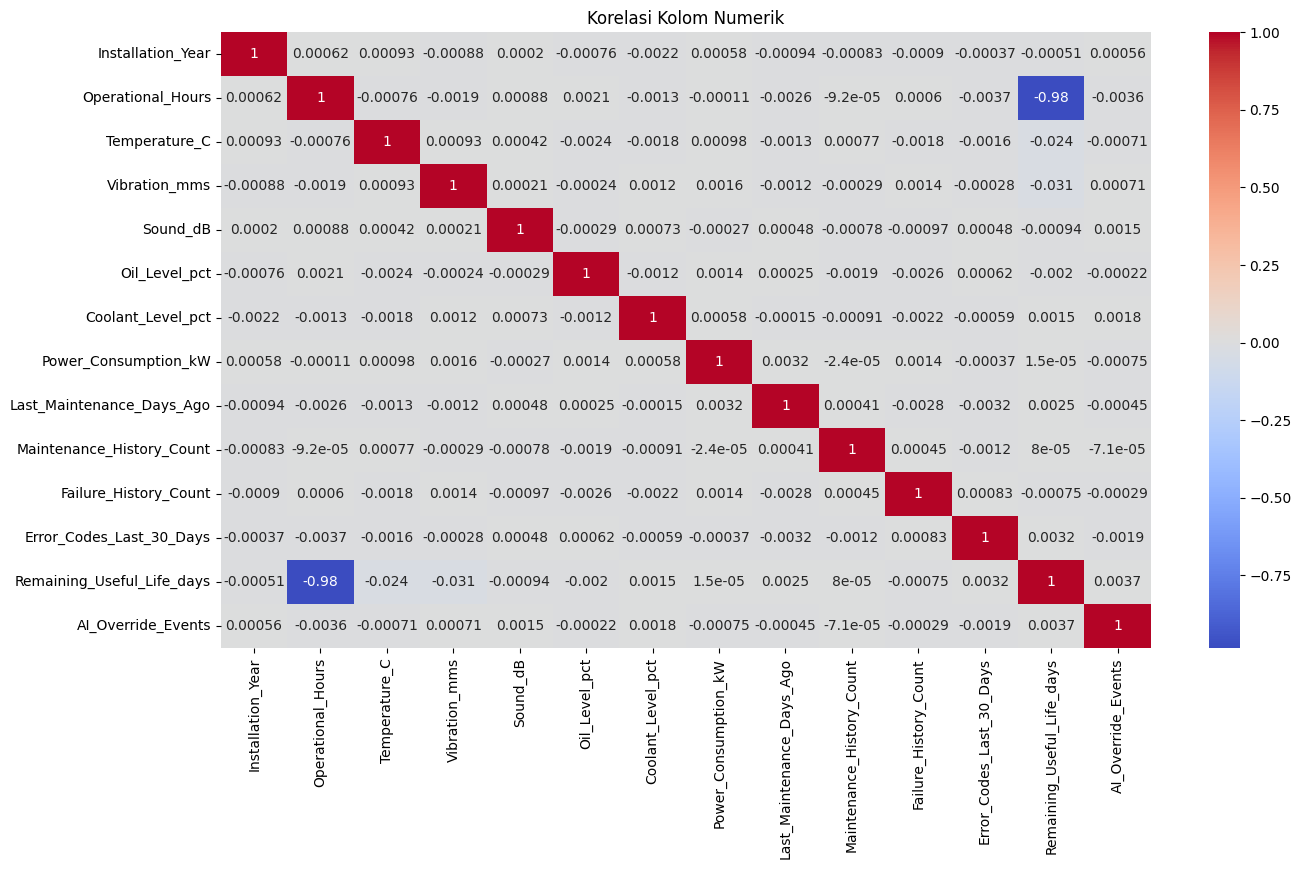

In [15]:
# 2. Bagaimana korelasi kolom target dengan kolom numerik lainnya

kolom_numerik = data.select_dtypes(include='number')
korelasi = kolom_numerik.corr()

# grafik korelasi

plt.figure(figsize=(15, 8))
sns.heatmap(korelasi, annot=True, cmap='coolwarm')
plt.title('Korelasi Kolom Numerik')
plt.show()

Remaining_useful_Life_day memiliki korelasi yang kuat **secara negatif dengan kegagalan, dengan nilai -0.98 yang artinya makin naik nilai kolom useful maka makin turun tingkat kegagalan, sedangkan sebaliknya makin kecil nilai useful tersebut maka makin tinggi tingkat kegagalan suatu mesin**

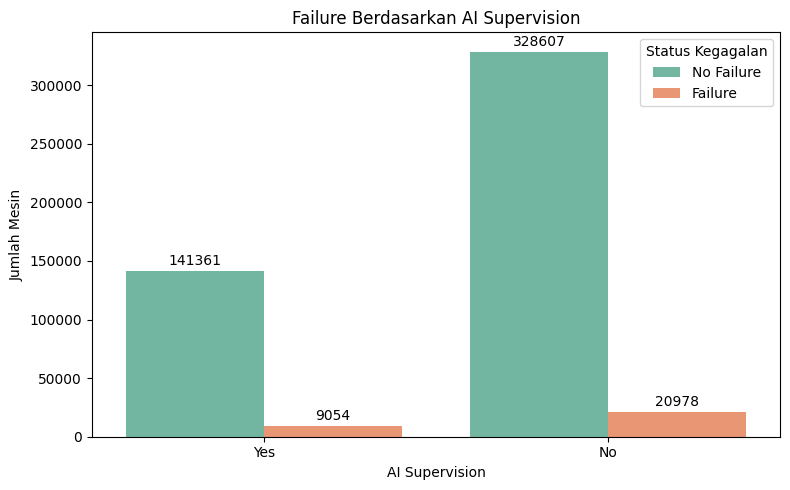

In [16]:
# 3. apakah pengawasan ai berdampak mengurangi kegagalan?

# Pastikan kolom boolean di-mapping agar labelnya lebih jelas
data['AI_Supervision'] = data['AI_Supervision'].map({True: 'Yes', False: 'No'})
data['Failure_Within_7_Days'] = data['Failure_Within_7_Days'].map({True: 'Failure', False: 'No Failure'})

# a. Buat barplot untuk ai_supervision
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=data, x='AI_Supervision', hue='Failure_Within_7_Days', palette='Set2')

# Tambahkan label di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

plt.title('Failure Berdasarkan AI Supervision')
plt.xlabel('AI Supervision')
plt.ylabel('Jumlah Mesin')
plt.legend(title='Status Kegagalan')
plt.tight_layout()
plt.show()

In [17]:
# value masing-masing ai

data['AI_Supervision'].value_counts(normalize=True) * 100

,proportion
AI_Supervision,
No,69.917
Yes,30.083


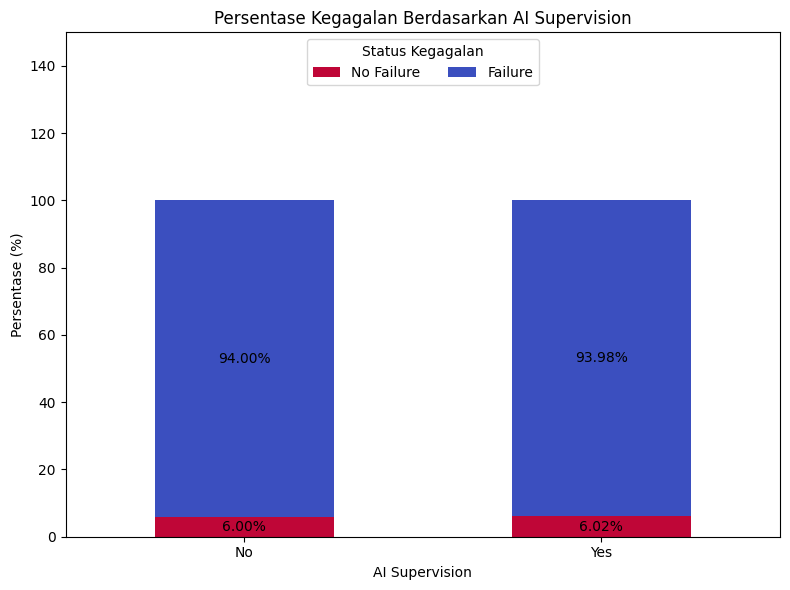

In [18]:
grouped = data.groupby(['AI_Supervision', 'Failure_Within_7_Days']).size().unstack(fill_value=0)

# Ganti nama kolom untuk kejelasan
grouped.columns = ['No Failure', 'Failure']

# Hitung persentase dari tiap baris
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot stacked bar
ax = grouped_percent.plot(kind='bar', stacked=True, color=['#BF0637', '#3B4FBF'], figsize=(8,6))

# Tambahkan label persentase di dalam bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=10, color='black')

# Kustomisasi plot
plt.title('Persentase Kegagalan Berdasarkan AI Supervision')
plt.ylabel('Persentase (%)')
plt.xlabel('AI Supervision')
plt.legend(title='Status Kegagalan', loc='upper center', ncol=2)
plt.ylim(0, 150)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

Mayoritas mesin belum diawasi oleh AI (69%)
- Sebagian besar mesin belum menggunakan pengawasan AI, menunjukkan bahwa adopsi AI supervision masih rendah di sistem operasional saat ini.

dan jika dilihat pada grafik ke 2, presentase kegagalan antara mesin yang sudah berbasis Ai dengan Belum, tidak ada perbedaan yang signifikan dari hal tersebut


<ipython-input-19-6ccb239f7564>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Failure_Within_7_Days', y='AI_Override_Events', palette='Set1')


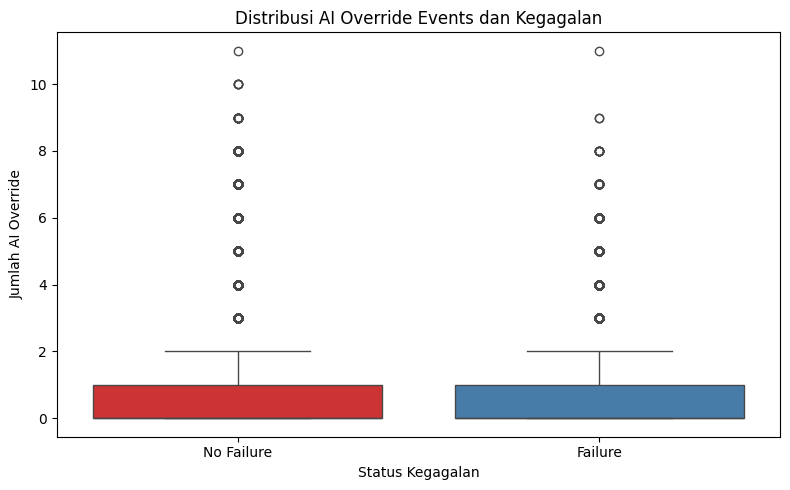

Rata-rata AI Override Events:
Failure_Within_7_Days
Failure       0.592368
No Failure    0.602720
Name: AI_Override_Events, dtype: float64


In [19]:
# b. Boxplot: Distribusi AI Override Events berdasarkan Failure
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Failure_Within_7_Days', y='AI_Override_Events', palette='Set1')
plt.title('Distribusi AI Override Events dan Kegagalan')
plt.xlabel('Status Kegagalan')
plt.ylabel('Jumlah AI Override')
plt.tight_layout()
plt.show()

# c. Mean override per class (statistik pendukung)
mean_override = data.groupby('Failure_Within_7_Days')['AI_Override_Events'].mean()
print("Rata-rata AI Override Events:")
print(mean_override)

Insight dari Distribusi AI Override Events:
1. Rata-rata hampir sama
- Mesin yang tidak gagal dalam 7 hari memiliki rata-rata AI_Override_Events = 0.6207

- Mesin yang mengalami kegagalan dalam 7 hari memiliki rata-rata = 0.5924

- Selisihnya sangat kecil → menunjukkan bahwa frekuensi override tidak secara signifikan membedakan mesin yang gagal vs. tidak gagal.

2. Distribusi mirip dan simetris
Boxplot untuk kedua kelas (Failure dan No Failure) memiliki median dan IQR yang hampir sama. Ini berarti AI_Override_Events **tidak memiliki pengaruh yang kuat atau linear terhadap kemungkinan terjadinya kegagalan**.

<ipython-input-20-b60cbc4cee00>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


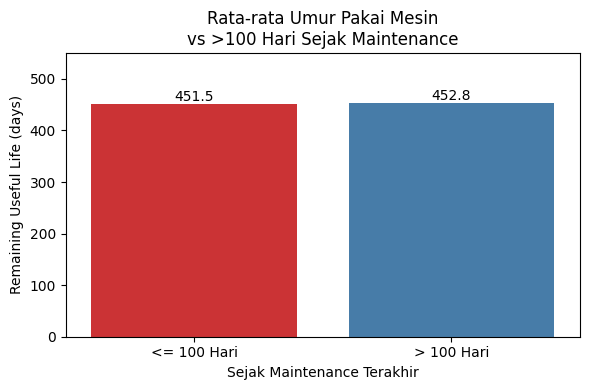

In [20]:
# 1. Apakah mesin yang terakhir diperbaiki lebih dari 100 hari lalu (Last_Maintenance_Days_Ago) lebih berisiko gagal?

# Tambahkan kolom kategori
# data_100hari = data['Last_Maintenance_Days_Ago'] > 100
data['Maintenance_Over_100_Days'] = data['Last_Maintenance_Days_Ago'] > 100

# Grup data
grouped_data = data.groupby('Maintenance_Over_100_Days')['Remaining_Useful_Life_days'].mean().reset_index()

# Ubah tipe kolom agar labelnya lebih informatif
grouped_data['Maintenance_Over_100_Days'] = grouped_data['Maintenance_Over_100_Days'].map({False: '<= 100 Hari', True: '> 100 Hari'})

# Visualisasi
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=grouped_data,
    x='Maintenance_Over_100_Days',
    y='Remaining_Useful_Life_days',
    palette='Set1'
)
plt.title('Rata-rata Umur Pakai Mesin\nvs >100 Hari Sejak Maintenance')
plt.xlabel('Sejak Maintenance Terakhir')
plt.ylabel('Remaining Useful Life (days)')
plt.ylim(0,550)

# Tambahkan label nilai di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.25, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<ipython-input-21-db5809cebae1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


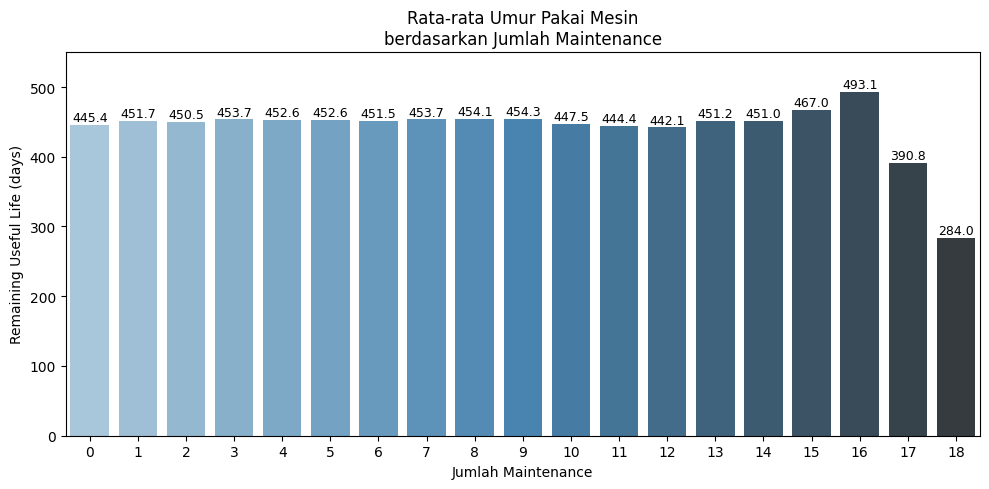

In [21]:
# 2. Apakah semakin sering mesin dirawat (Maintenance_History_Count), semakin panjang Remaining_Useful_Life_days?

# Grouping
grouped_data = data.groupby('Maintenance_History_Count')['Remaining_Useful_Life_days'].mean().reset_index()

# Sort jika ingin urut dari sedikit ke banyak
grouped_data = grouped_data.sort_values('Maintenance_History_Count')

# Visualisasi
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=grouped_data,
    x='Maintenance_History_Count',
    y='Remaining_Useful_Life_days',
    palette='Blues_d'
)

plt.title('Rata-rata Umur Pakai Mesin\nberdasarkan Jumlah Maintenance')
plt.xlabel('Jumlah Maintenance')
plt.ylabel('Remaining Useful Life (days)')
plt.ylim(0,550)

# Tambahkan label angka di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<ipython-input-22-ea0b21265dfd>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby('Temp_Bin')['Power_Consumption_kW'].mean().reset_index()
<ipython-input-22-ea0b21265dfd>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


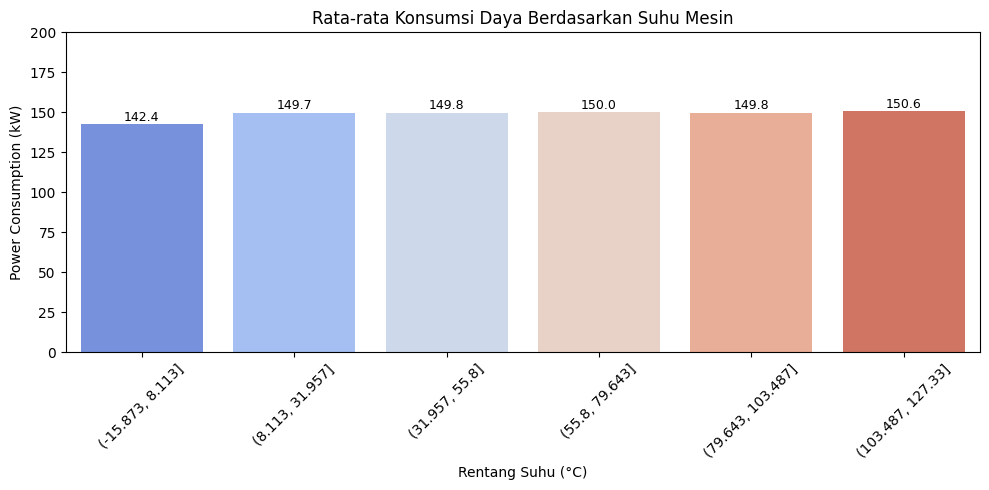

In [22]:
# Apakah semakin tinggi suhu mesin maka konsumsi tenaga semakin tinggi juga?

# Buat bin suhu
data['Temp_Bin'] = pd.cut(data['Temperature_C'], bins=6)

# Group berdasarkan bin suhu
grouped_data = data.groupby('Temp_Bin')['Power_Consumption_kW'].mean().reset_index()

# Visualisasi
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=grouped_data,
    x='Temp_Bin',
    y='Power_Consumption_kW',
    palette='coolwarm'
)

plt.title('Rata-rata Konsumsi Daya Berdasarkan Suhu Mesin')
plt.xlabel('Rentang Suhu (°C)')
plt.ylabel('Power Consumption (kW)')
plt.xticks(rotation=45)
plt.ylim(0,200)

# Tambahkan label nilai di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Machine_Type                500000 non-null  object  
 1   Installation_Year           500000 non-null  int64   
 2   Operational_Hours           500000 non-null  int64   
 3   Temperature_C               500000 non-null  float64 
 4   Vibration_mms               500000 non-null  float64 
 5   Sound_dB                    500000 non-null  float64 
 6   Oil_Level_pct               500000 non-null  float64 
 7   Coolant_Level_pct           500000 non-null  float64 
 8   Power_Consumption_kW        500000 non-null  float64 
 9   Last_Maintenance_Days_Ago   500000 non-null  int64   
 10  Maintenance_History_Count   500000 non-null  int64   
 11  Failure_History_Count       500000 non-null  int64   
 12  AI_Supervision              500000 non-null  object  
 13 

In [24]:
data.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events,Maintenance_Over_100_Days,Temp_Bin
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,Yes,3,162.0,No Failure,2,True,"(55.8, 79.643]"
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,Yes,4,147.0,No Failure,2,True,"(55.8, 79.643]"
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,Yes,6,0.0,Failure,2,True,"(31.957, 55.8]"
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,No,4,161.0,No Failure,0,False,"(55.8, 79.643]"
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,No,1,765.0,No Failure,0,True,"(31.957, 55.8]"


# Model Random Forest

In [25]:
ML = data.copy()

In [26]:
# pemilihan x dan y

x = ML.drop(['Failure_Within_7_Days','Maintenance_Over_100_Days', 'Temp_Bin' ], axis=1)
y = ML['Failure_Within_7_Days']

In [27]:
# encoding kolom kategory

from sklearn.preprocessing import StandardScaler, LabelEncoder

x['Machine_Type'] = LabelEncoder().fit_transform(x['Machine_Type'])
# x['AI_Supervision'] = x['AI_Supervision'].astype(int)  # jika masih bool
x['AI_Supervision'] = x['AI_Supervision'].map({'Yes': 1, 'No': 0}).astype(int)


In [28]:
# split data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [29]:
# Smote data train untuk menghilangkan imbalance

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [31]:
# model randomforest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [32]:
# test model pada data train

y_pred_train = rf.predict(x_train_resampled)
print("Akurasi pada data train:", accuracy_score(y_train_resampled, y_pred_train))

Akurasi pada data train: 1.0


nilai akurasi dari model setelah di terapkan pada data train adalah 1, namun hal ini tidak bisa langsung disimpulkan bahwa model sangat bagus, kita akan lakukan beberapa pengecekan terlebih dahulu untuk menentukan apakah model ini tidak overfitting

1. coba terapkan model pada datatest, dan cek akurasinya
2. lakukan cross-validasi pada data train tersebut
3. lalu lakukan pengecekan feature importance


In [33]:
# prediksi

y_pred = rf.predict(x_test)

#evaluasi

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Confusion Matrix:
 [[ 5960     0]
 [    0 94040]]

Classification Report:
               precision    recall  f1-score   support

     Failure       1.00      1.00      1.00      5960
  No Failure       1.00      1.00      1.00     94040

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



pada penerapan model di data test masih didapatkan nilai akurasi 100% sehingga akan dilanjutkan pengecekan overfitting

In [34]:
# check overfiting

cv_scores = cross_val_score(rf, x_train_resampled, y_train_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


pada pengecekan CV- Score pun masih di dapatkan akurasi 1 pada model, lanjutkan untuk mengetahui feature importance untuk mengetahui apakah model terlalu bergantung pada beberapa fitur tertentu saja.

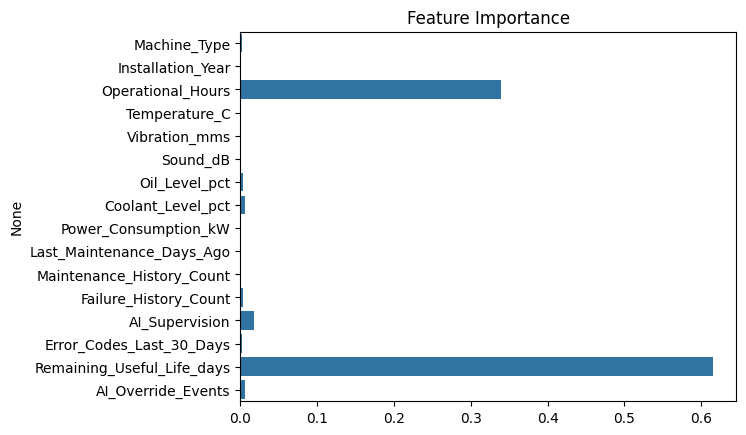

In [ ]:
# check feature importance

feature_importances = rf.feature_importances_
feature_names = x_train_resampled.columns
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

In [ ]:
# penjelasan dalam persentase feature yang berpengaruh tersebut

for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance * 100:.2f}%")

Machine_Type: 0.18%
Installation_Year: 0.06%
Operational_Hours: 33.97%
Temperature_C: 0.04%
Vibration_mms: 0.10%
Sound_dB: 0.02%
Oil_Level_pct: 0.38%
Coolant_Level_pct: 0.63%
Power_Consumption_kW: 0.01%
Last_Maintenance_Days_Ago: 0.01%
Maintenance_History_Count: 0.13%
Failure_History_Count: 0.36%
AI_Supervision: 1.77%
Error_Codes_Last_30_Days: 0.20%
Remaining_Useful_Life_days: 61.50%
AI_Override_Events: 0.63%


berdasarkan grafik dan persentase feature yang berpengatuh adalah:

1. Remaining_Useful_life_days : 61.50%
2. Operational_Hours : 33.97%
3. AI_Supervision : 1.77%

sedangkan feature yang lainnya dibawah 1%, ini menandakan bahwa tingkat kegagalan sebuah mesin industri sangat bergantung pada sudah berapa hari lama mesin tersebut berfungsi dengan baik.

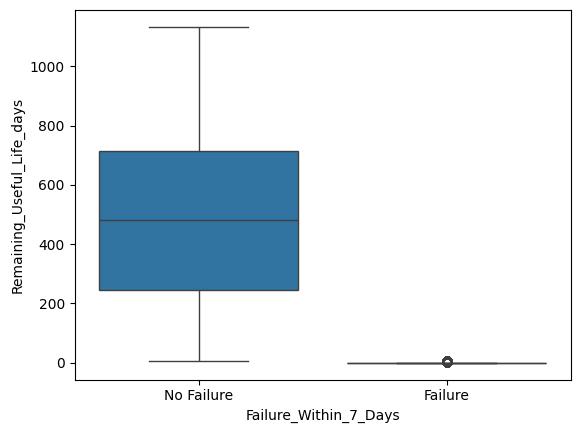

In [35]:
# cek data leak berdasarkan target dan fitur yang mendominasi

sns.boxplot(x='Failure_Within_7_Days', y='Remaining_Useful_Life_days', data=data)
plt.show()

# Random forest 2 without remaining useful

In [ ]:
# random forest

ML_2 = ML.copy()

In [ ]:
# tentukan x dan y

x_2 = ML_2.drop(['Failure_Within_7_Days','Maintenance_Over_100_Days', 'Temp_Bin', 'Remaining_Useful_Life_days' ], axis=1)
y_2 = ML_2['Failure_Within_7_Days']

In [ ]:
# encoding

x_2['Machine_Type'] = LabelEncoder().fit_transform(x_2['Machine_Type'])
x_2['AI_Supervision'] = x_2['AI_Supervision'].map({'Yes': 1, 'No': 0}).astype(int)

In [ ]:
# split data

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.2, random_state=42)

In [ ]:
# smote data

smote_2 = SMOTE(random_state=42)
x_train_resampled_2, y_train_resampled_2 = smote_2.fit_resample(x_train_2, y_train_2)

In [ ]:
# model

rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2.fit(x_train_resampled_2, y_train_resampled_2)

RandomForestClassifier(random_state=42)

In [ ]:
# terapkan model pada data train

y_pred_train_2 = rf_2.predict(x_train_resampled_2)
print("Akurasi pada data train:", accuracy_score(y_train_resampled_2, y_pred_train_2))

Akurasi pada data train: 0.9999866995807708


In [ ]:
# terapkan pada data test

y_pred_2 = rf_2.predict(x_test_2)

# evaluasi

print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_2, y_pred_2))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred_2))

Accuracy: 0.94872

Confusion Matrix:
 [[ 5186   774]
 [ 4354 89686]]

Classification Report:
               precision    recall  f1-score   support

     Failure       0.54      0.87      0.67      5960
  No Failure       0.99      0.95      0.97     94040

    accuracy                           0.95    100000
   macro avg       0.77      0.91      0.82    100000
weighted avg       0.96      0.95      0.95    100000



In [ ]:
# check overfitting

cv_scores_2 = cross_val_score(rf_2, x_train_resampled_2, y_train_resampled_2, cv=5)
print("Cross-Validation Scores:", cv_scores_2)

Cross-Validation Scores: [0.95679382 0.97296686 0.97319297 0.97385799 0.97303336]


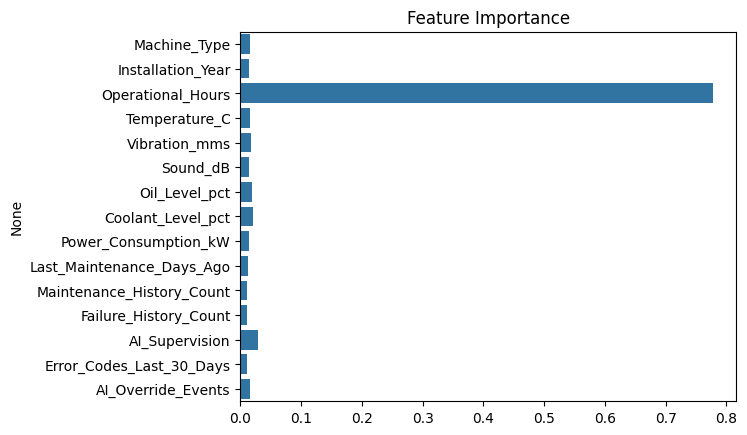

In [ ]:
# importance feature

feature_importances_2 = rf_2.feature_importances_
feature_names_2 = x_train_resampled_2.columns
sns.barplot(x=feature_importances_2, y=feature_names_2)
plt.title('Feature Importance')
plt.show()

# RF without remaining life dan operation hour

In [51]:
# random forest 3

ML_3 = data.copy()

In [52]:
# tentukan x dan y

x_3 = ML_3.drop(['Failure_Within_7_Days','Maintenance_Over_100_Days', 'Temp_Bin', 'Operational_Hours', 'Remaining_Useful_Life_days'], axis=1)
y_3 = ML_3['Failure_Within_7_Days']

In [53]:
# encoding

x_3['Machine_Type'] = LabelEncoder().fit_transform(x_3['Machine_Type'])
x_3['AI_Supervision'] = x_3['AI_Supervision'].map({'Yes': 1, 'No': 0}).astype(int)

In [54]:
# split data

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, test_size=0.2, random_state=42)

In [55]:
# smote

smote_3 = SMOTE(random_state=42)
x_train_resampled_3, y_train_resampled_3 = smote_3.fit_resample(x_train_3, y_train_3)

In [56]:
# model randomforest

rf_3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_3.fit(x_train_resampled_3, y_train_resampled_3)

RandomForestClassifier(random_state=42)

In [57]:
# terapkan pada datatrain

y_pred_train_3 = rf_3.predict(x_train_resampled_3)
print("Akurasi pada data train:", accuracy_score(y_train_resampled_3, y_pred_train_3))

Akurasi pada data train: 1.0


In [58]:
# terapkan pada datatest

y_pred_3 = rf_3.predict(x_test_3)

# evaluasi

print("Accuracy:", accuracy_score(y_test_3, y_pred_3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_3, y_pred_3))
print("\nClassification Report:\n", classification_report(y_test_3, y_pred_3))

Accuracy: 0.82475

Confusion Matrix:
 [[  852  5108]
 [12417 81623]]

Classification Report:
               precision    recall  f1-score   support

     Failure       0.06      0.14      0.09      5960
  No Failure       0.94      0.87      0.90     94040

    accuracy                           0.82    100000
   macro avg       0.50      0.51      0.50    100000
weighted avg       0.89      0.82      0.85    100000



In [59]:
# cek overfitting

cv_scores_3 = cross_val_score(rf_3, x_train_resampled_3, y_train_resampled_3, cv=5)
print("Cross-Validation Scores:", cv_scores_3)

Cross-Validation Scores: [0.8147594  0.89009184 0.89102952 0.8919805  0.89080341]


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

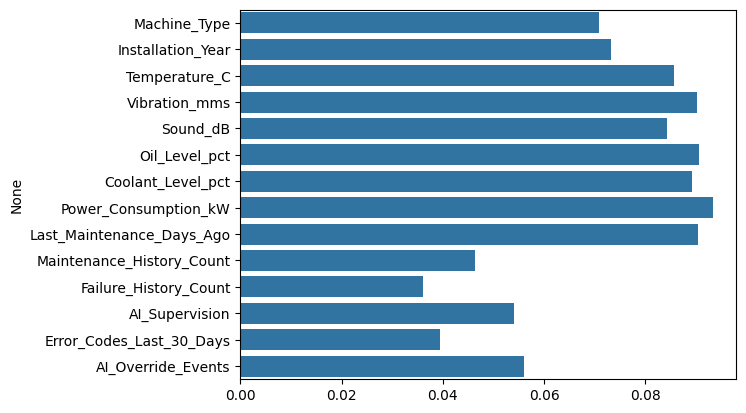

In [60]:
# importance feature

feature_importances_3 = rf_3.feature_importances_
feature_names_3 = x_train_resampled_3.columns
sns.barplot(x=feature_importances_3, y=feature_names_3)
plt.title

setelah didapatkan beberapa feature importance ini kita akan coba buatkan model baru untuk penerapannya pilihan feature nya

- machine type
- installation year
- oil level
- coolant level
- power consumption
- last maintenance days

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Machine_Type                500000 non-null  object  
 1   Installation_Year           500000 non-null  int64   
 2   Operational_Hours           500000 non-null  int64   
 3   Temperature_C               500000 non-null  float64 
 4   Vibration_mms               500000 non-null  float64 
 5   Sound_dB                    500000 non-null  float64 
 6   Oil_Level_pct               500000 non-null  float64 
 7   Coolant_Level_pct           500000 non-null  float64 
 8   Power_Consumption_kW        500000 non-null  float64 
 9   Last_Maintenance_Days_Ago   500000 non-null  int64   
 10  Maintenance_History_Count   500000 non-null  int64   
 11  Failure_History_Count       500000 non-null  int64   
 12  AI_Supervision              500000 non-null  object  
 13 

In [79]:
# dataset baru

ML_4 = data.copy()

In [80]:
# 6 feature yang digunakan

feature_4 = ['Machine_Type', 'Installation_Year', 'Oil_Level_pct', 'Coolant_Level_pct', 'Power_Consumption_kW', 'Last_Maintenance_Days_Ago']

# tentukan x dan y

x_4 = ML_4[feature_4]
y_4 = ML_4['Failure_Within_7_Days']

In [81]:
# encode

x_4['Machine_Type'] = LabelEncoder().fit_transform(x_4['Machine_Type'])

<ipython-input-81-dd3fd52424af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_4['Machine_Type'] = LabelEncoder().fit_transform(x_4['Machine_Type'])


In [82]:
# split dataset

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_4, y_4, test_size=0.2, random_state=42)

In [83]:
# smote

smote_4 = SMOTE(random_state=42)
x_train_resampled_4, y_train_resampled_4 = smote_4.fit_resample(x_train_4, y_train_4)

In [84]:
# model

rf_4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_4.fit(x_train_resampled_4, y_train_resampled_4)

RandomForestClassifier(random_state=42)

In [85]:
# terapkan pada data train

y_pred_train_4 = rf_4.predict(x_train_resampled_4)
print("Akurasi pada data train:", accuracy_score(y_train_resampled_4, y_pred_train_4))

Akurasi pada data train: 1.0


In [86]:
# terapkan pada data test

y_pred_4 = rf_4.predict(x_test_4)

# evaluasi

print("Accuracy:", accuracy_score(y_test_4, y_pred_4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_4, y_pred_4))
print("\nClassification Report:\n", classification_report(y_test_4, y_pred_4))

Accuracy: 0.85113

Confusion Matrix:
 [[  622  5338]
 [ 9549 84491]]

Classification Report:
               precision    recall  f1-score   support

     Failure       0.06      0.10      0.08      5960
  No Failure       0.94      0.90      0.92     94040

    accuracy                           0.85    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.89      0.85      0.87    100000



In [87]:
# check overfiting

cv_scores_4 = cross_val_score(rf_4, x_train_resampled_4, y_train_resampled_4, cv=5)
print("Cross-Validation Scores:", cv_scores_4)

Cross-Validation Scores: [0.8872596  0.90267405 0.90215534 0.90381789 0.90077874]


In [88]:
# simpan model

import joblib

joblib.dump(rf_4, 'model_rf_4.pkl')

['model_rf_4.pkl']

In [89]:
# simpan encoder

import joblib

joblib.dump(LabelEncoder(), 'encoder.pkl')

['encoder.pkl']

In [92]:
# simpan model dalam joblib

import joblib

joblib.dump(rf_4, 'model_rf_4.joblib', compress=9)

['model_rf_4.joblib']